In [10]:
import MeCab
import pandas as pd
import re
import itertools
from src.vectrizer import ContentVectorizer
from src.clustering import ClustarGenerator
from src.network_generater import NetworkGenerater
import math
import numpy as np

cv = ContentVectorizer()
cg = ClustarGenerator()
ng = NetworkGenerater()

# ユーザー辞書を設定
m_t = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u test/fragrance_user_dic.dic')

# メタ付与する文章を読み込み
article_df = pd.read_table('data/perfume_sentence.tsv')

colname = ['surface', 'pos1', 'pos2', 'empty1', 'empty2', 'empty3', 'empty4', 'nomarization', 'category1', 'empty5', 'empty6', 'empty7', 'empty8', 'empty9', 'pos3', 'empty10', 'sign']

In [2]:
# 学習済みベクトルを差し替える

#model_path = "model/awg_word2vec.model"
#cv.load_model(model_path)
#cv.ginza.vocab.vectors.shape

In [3]:
# 辞書から特定のカテゴリーに属するワードを抽出する
feature = []
word_class = []
wlstr_ = []
empty_w = [] # ベクトル化できない単語（ゼロベクトルリスト）

for i, sentence in enumerate(article_df['description']):
    parsed_s = m_t.parse(sentence).replace('\t',',').split('\n')
    parsed_results = pd.Series(parsed_s).str.split(',').tolist()
    df_raw = pd.DataFrame(parsed_results, columns = colname)
    # 'category1'に「香り」か「印象」属性が登録されている単語をDataFarameに登録
    f_df = df_raw[(df_raw['category1'] == '香り') | (df_raw['category1'] =='印象')]

    # 単語と香りor印象属性を抽出する
    f_m = []
    attr_dic = {}
    for s,c in zip(f_df['surface'],f_df['category1']):
        doc,vector = cv.vectorize(s)
        attr_dic = {'word':doc,'category':c}
        if vector.all():
            if str(doc) not in wlstr_:
                word_class.append(doc)
                wlstr_.append(str(doc))
            f_m.append(attr_dic)
        else:
            empty_w.append(doc)
    feature.append(f_m)
    
empty_w

[マンダリン,
 パチョリ,
 ベルガモット,
 アロマティック,
 サボン,
 イチゴ,
 イチゴ,
 イチゴ,
 かき氷,
 キャンディ,
 イチゴ,
 マンダリン,
 ウッディ,
 マンダリン,
 シダー,
 ウッディ,
 サボン,
 ベルガモット,
 マンダリン,
 ナツメグ,
 ムスク,
 マンダリン,
 ベチバー,
 シダー,
 ヒヤシンス,
 フリージア,
 フルーティ,
 とろける,
 ヒヤシンス,
 フリージア,
 ピオニー,
 ライチ,
 ムスク,
 モテる,
 ピオニー,
 モテる,
 フリージア,
 ランバン,
 みずみずしい,
 愛され,
 ムスク,
 スイートピー,
 モテる,
 愛され,
 モテる,
 グルマン,
 サボン,
 まろやか,
 フルーティ,
 アロマオイル,
 みずみずしい,
 ピオニー,
 ピオニー,
 月桂樹,
 ベルガモット,
 みずみずしい,
 ペアー,
 フリージア,
 みずみずしい,
 フリージア,
 パチョリ,
 ウッディ,
 ウッディ,
 ライチ,
 ウッディ,
 ウッディ,
 ウッディ,
 ウッディ,
 ウッディ,
 ムスク,
 ウッディ,
 ウッディ,
 ウッディ,
 ベチバー,
 ウッディ,
 ウッディ,
 ウッディ,
 フルーティ,
 ウッディ,
 ウッディ,
 ムスク,
 ウッディ,
 ムスク,
 ムスク,
 チュベローズ,
 マンダリン,
 奥ゆかしい,
 イチゴ,
 ペアー,
 フルーティ,
 ピオニー,
 パチョリ,
 マンダリン,
 モテる,
 チュベローズ,
 パチョリ,
 グルマン,
 ハーバル,
 シダー,
 サボン,
 ベルガモット,
 ムスク,
 ベチバー,
 ムスク,
 ベルガモット,
 ムスク,
 ベルガモット,
 ムスク,
 ムスク,
 ベルガモット,
 ムスク,
 月桂樹,
 ムスク,
 ムスク,
 ベルガモット,
 カルダモン,
 クローブ,
 ウッディ,
 チュベローズ,
 チュベローズ,
 ムスク,
 ウッディ,
 チュベローズ,
 チュベローズ,
 チュベローズ,
 チュベローズ,
 ベルガモット,
 ライチ,
 柑橘類,
 ベルガモット,
 弾ける,
 フリージア,
 ベルガモット,
 カルダモン,
 ハーバル,
 ムスク,
 弾ける,
 ハーバル,
 パチュリ

In [4]:
meta_parts_pairs = []
for pair in itertools.combinations(word_class, 2):
    meta_parts_pairs.append(pair)
    
score = []
for doc1,doc2 in meta_parts_pairs:
    score.append(doc1.similarity(doc2))
    
target_df = pd.DataFrame(meta_parts_pairs)
target_df['2']=score

target_df
#target_df_dummy = pd.DataFrame([['rose', 'cute', 0.124353], ['lemon', 'herb', 0.0098163], ['beautifle', 'elegance', 0.000384627]])

,0,1,2
0,(ローズ),"(ダマスク, ローズ)",1.000000
1,(ローズ),(優雅),0.356119
2,(ローズ),(ふんわり),0.352181
3,(ローズ),(レモン),0.464299
4,(ローズ),"(尖っ, た)",0.321487
...,...,...,...
10291,(幸福),(奥深い),0.187721
10292,(幸福),"(キリッ, と, し, た)",0.150995
10293,(繊細),(奥深い),0.492646
10294,(繊細),"(キリッ, と, し, た)",0.334388


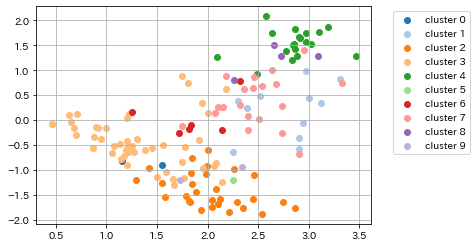

In [5]:
# クラスタリング

vectorlist = np.array([w.vector for w in word_class])

n_cluster = 10

cluster_result = cg.generate(title_list=word_class, 
            vector_list=vectorlist, 
            vector_size=100, 
            n_cluster = n_cluster)

In [6]:
# クラスタリング結果

cluster_result[0]

[深い, 奥深い]

In [7]:
# クラスタごとのネットワークを作成

cluster_word = cluster_result[0]

cluster_result_dict = {}

for class_id , cluster_word in cluster_result.items():

    meta_parts_pairs = []
    for pair in itertools.combinations(cluster_word, 2):
        meta_parts_pairs.append(pair)

    score = []
    for doc1,doc2 in meta_parts_pairs:
        score.append(round(doc1.similarity(doc2),3))

    cluster_df = pd.DataFrame(meta_parts_pairs)
    cluster_df['2']=score

    cluster_result_dict[class_id]=cluster_df[cluster_df['2']>0.5].sort_values('2',ascending=False)

In [8]:
cluster_result_dict[0]

,0,1,2
0,(深い),(奥深い),0.683


# ネットワーク可視化

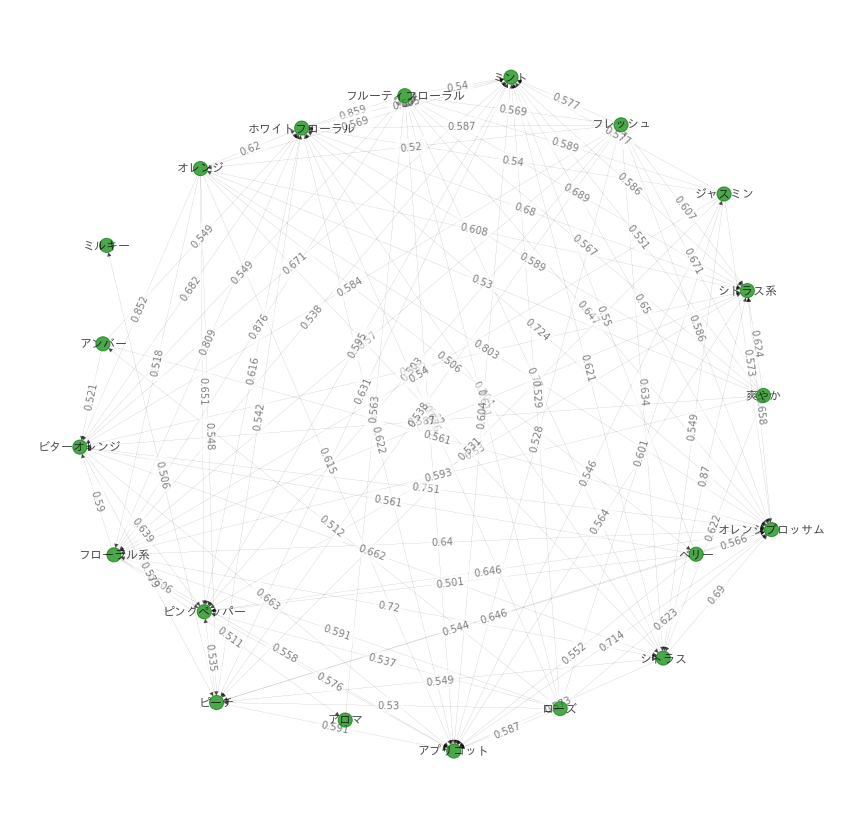

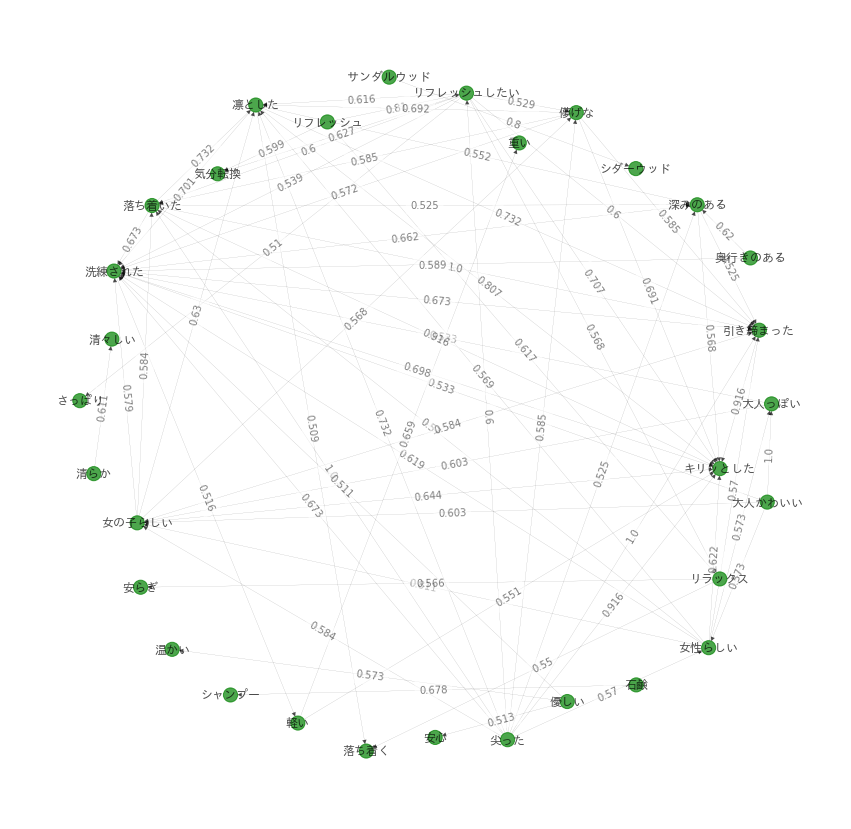

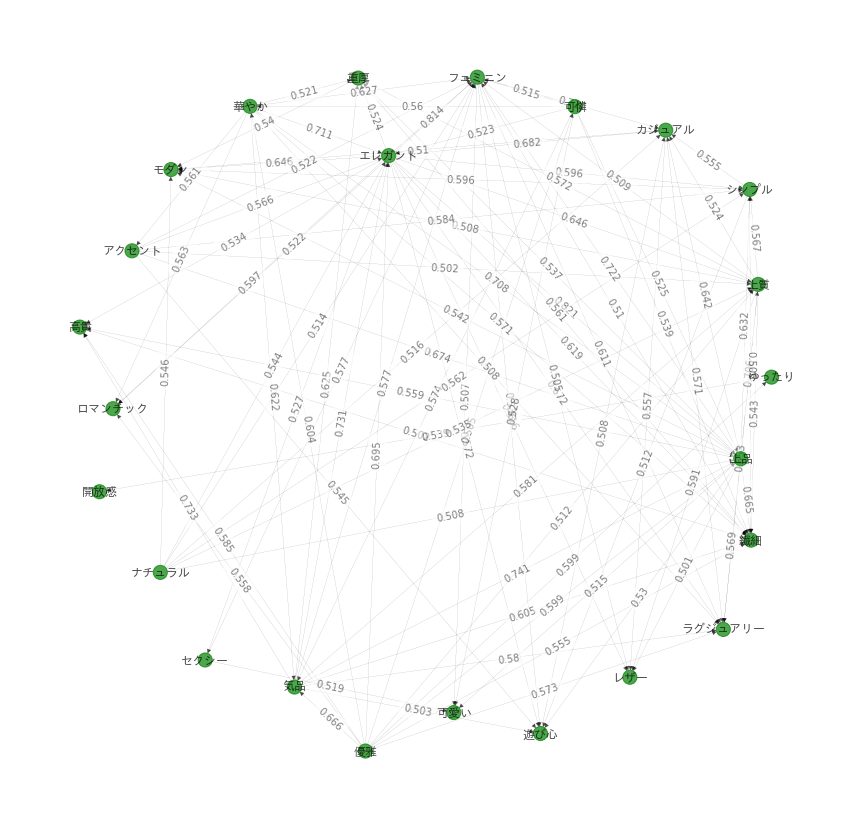

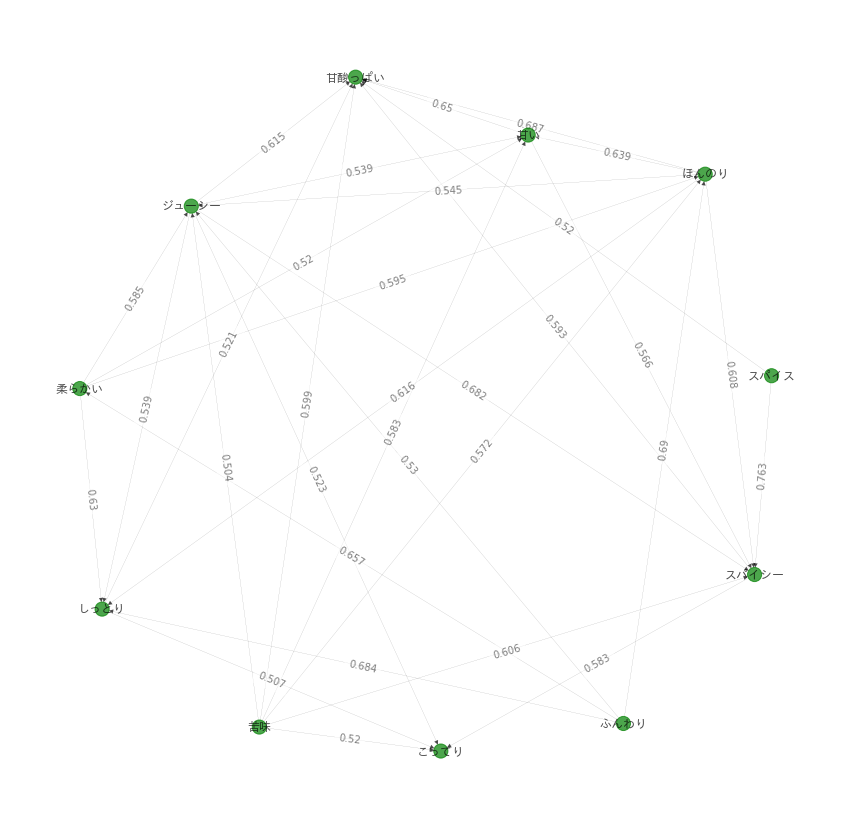

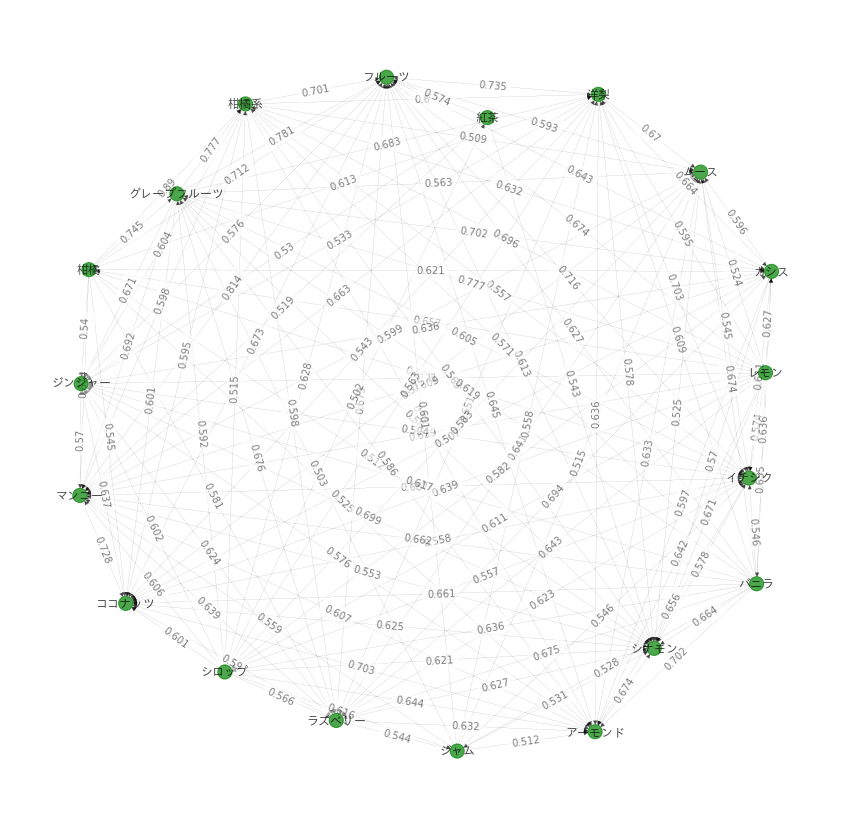

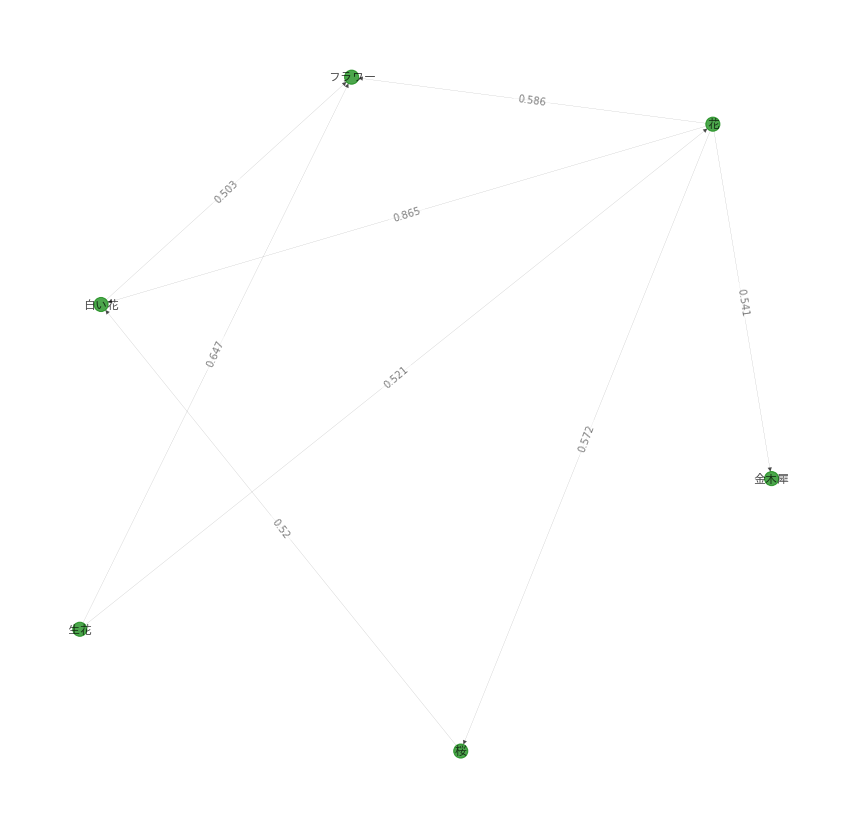

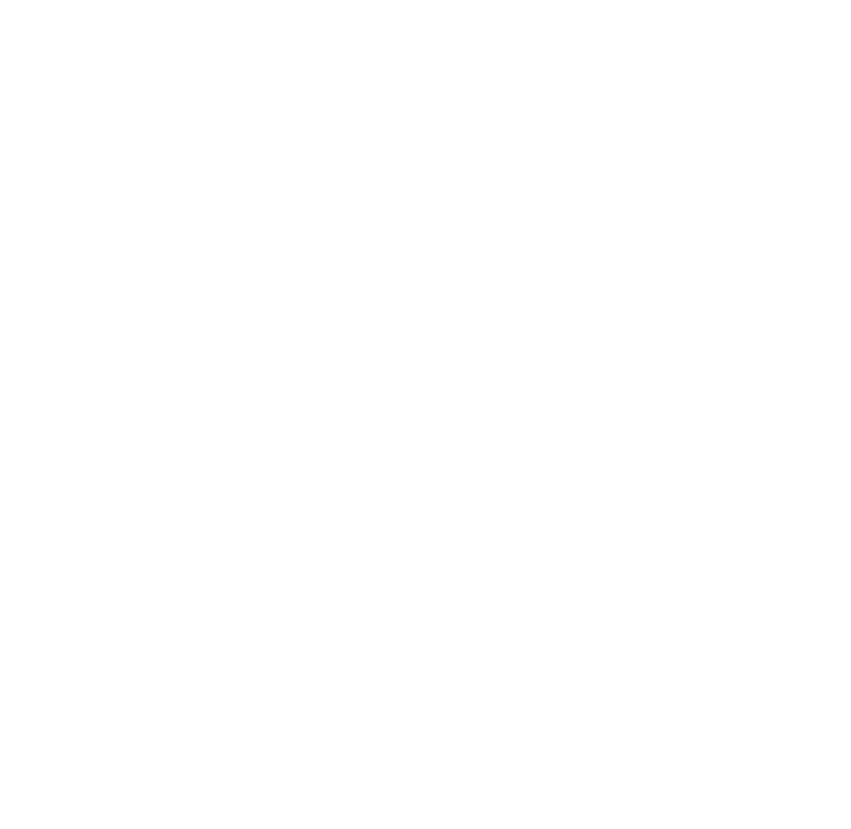

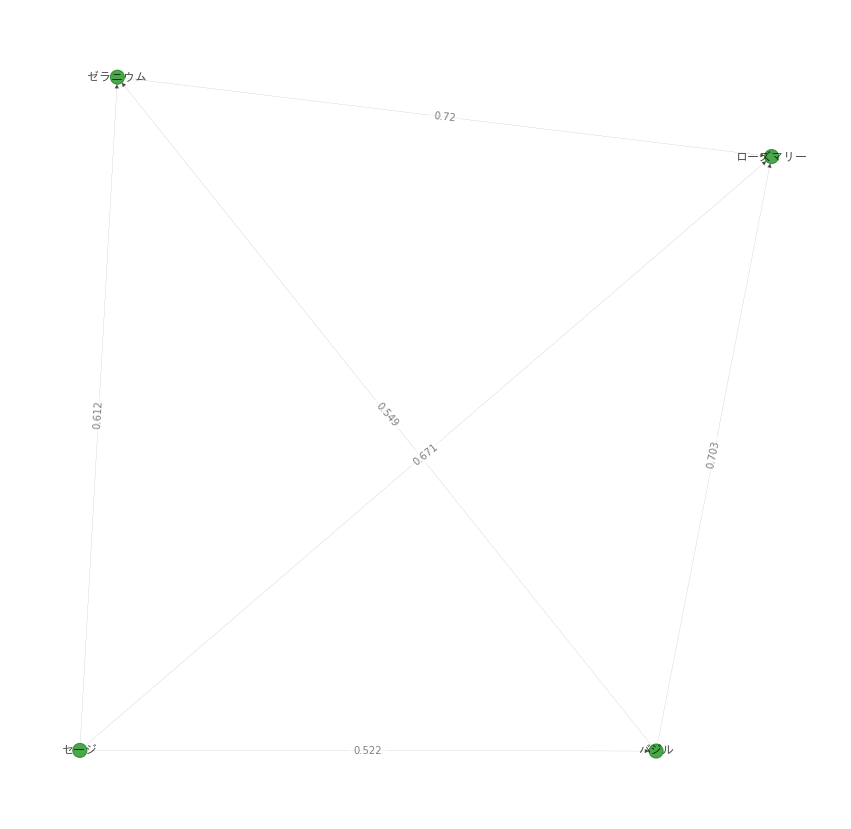

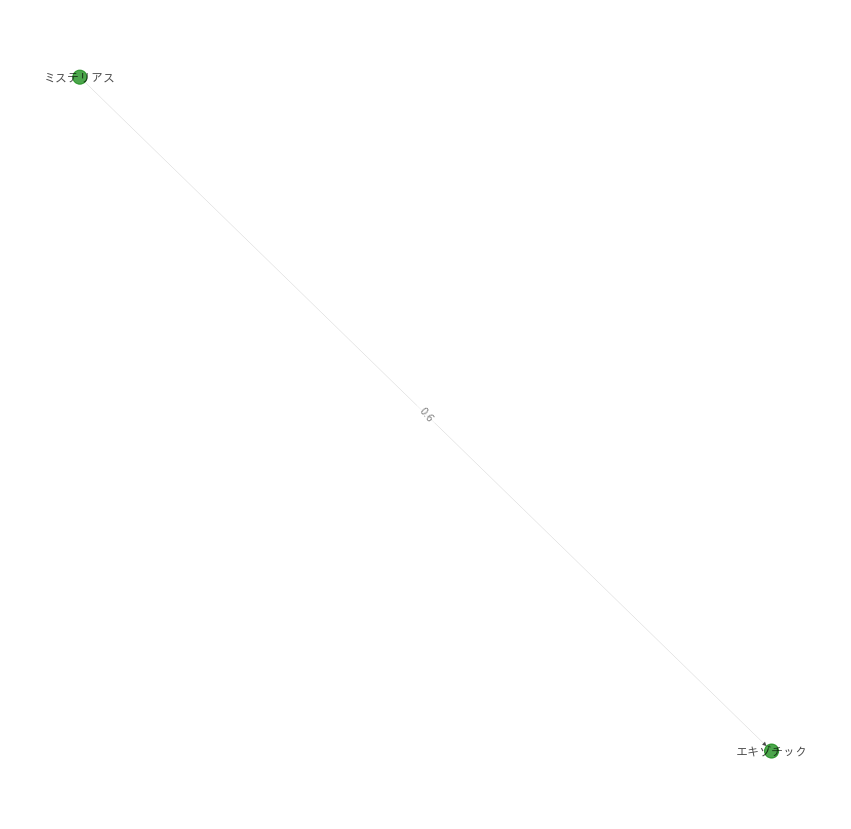

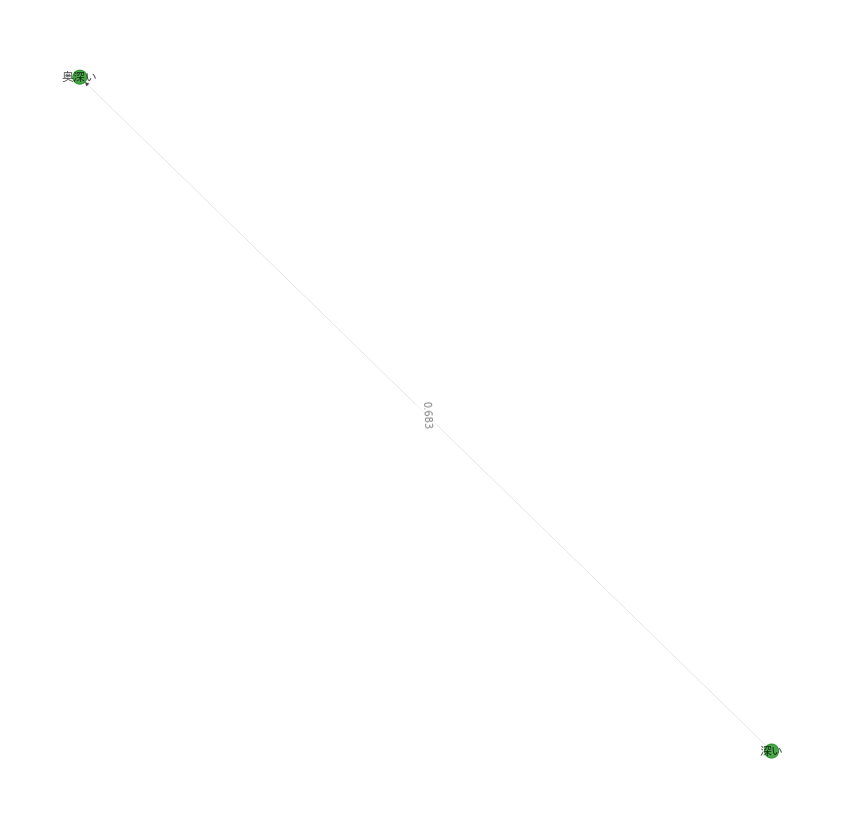

In [9]:
for clusterid, cluster in cluster_result_dict.items():
    ng.network(cluster.values.tolist(), 200, 0.005)